In [1]:
%load_ext autoreload
%autoreload 2

# XAI for Affective Computing - Counterfactuals with DiCE Tutorial
To use this notebook, please make sure to go step by step through each of the cells review the code and comments along the way.

Make sure to read the **README** beforing starting this notebook, to review the required Python packages. 

Download and extract [models.zip](https://uni-bielefeld.sciebo.de/s/KQteUW4ee3twM9S) to `models` folder to use the pretrained models

## Notebook Setup

Import necessary libraries

(see README for necessary package installations if you receive a `module not found` error.

In [2]:
import pickle
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# import tensorflow for model loading
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# required for ALIBI Contrastive Explanation Methods (CEM)
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs

# import sklearn for processing data and results
from sklearn.preprocessing import LabelBinarizer

from skimage import io

# import model loading function
from model import cnn_model

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
tf.config.list_physical_devices('GPU')

[]

Define Helper functions for plotting faces

In [3]:
# Helper Functions
def display_one_image(image, title, subplot, color='black', mask=None):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image, )
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, preds, start, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        idx = start+i
        display_one_image(images[idx], f'Actual={titles[idx]} \n Pred={preds[idx]} \n Index = {idx}', 331+i, color)
    # plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

Set Some Global Variables

In [4]:
SEED = 12
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 80 # set to 80 to easily load all images using image generator in one call
NUM_CLASSES = 8
CLASS_LABELS = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']

## Model and Data Loading

### CNN Model - Facial Expression Recognition from Images
This model is a pretrained Convolutional Neural Network for Facial Expression Recognition (FER) trained on raw images of people making facial expressions, from a subset of the [AffectNet dataset](http://mohammadmahoor.com/affectnet/). 

#### Load the pretrained model 


In [5]:
# make sure you've downloaded the models from LernraumPlus (see README instructions for Notebook I)
model_path = 'models/affectnet_model_e=60/affectnet_model'

# test loading weights
fer_cnn_model = cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES)
fer_cnn_model.load_weights(model_path)

2022-11-18 13:41:42.902994: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Load images
`ImageDataGenerator` is a [Keras utility class](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to easily load images for processing with a Keras model.

The numpy array `X_img` contains 80 images that we will use for explanations.  And `Y_img_true` stores the ground truth labels, encoded as [one hot vectors](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), for each image.

In [6]:
test_dir = 'data/affectnet/val_class/'

# Load data
test_datagen = ImageDataGenerator(validation_split=0.2,
                                  rescale=1./255)
test_gen = test_datagen.flow_from_directory(directory=test_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            color_mode='rgb',
                                            class_mode='categorical', 
                                            seed = SEED)
X_img, Y_img_true = next(test_gen)
Y_img_true_class = np.argmax(Y_img_true, axis=1)

Found 80 images belonging to 8 classes.


#### Evaluate model
Here we evaluate the loaded model to ensure it is working as expected.  You should get around $55\%$ accuracy. While this is not a perfect classifier is well random guessing which is $1 / 8 * 100 = 12.5$ accuracy

This is the same CNN model as before, so refer to our previous notebook to view more details on its performance.

We also get predictions of the model for the dataset, stored in `Y_img_pred`.

In [7]:
loss, acc = fer_cnn_model.evaluate(test_gen, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Restored model, accuracy: 55.00%


In [8]:
Y_img_pred = fer_cnn_model.predict(X_img)
Y_img_pred_class = np.argmax(Y_img_pred, axis=1)

### Random Decision Forest Model - Facial Expression Recognition from Facial Action Units

This model is a pretrained random decision forest (RDF) trained on the facial action units (FAUs) of people expression emotions extracted from the AffectNet dataset using [OpenFace](https://github.com/TadasBaltrusaitis/OpenFace).

Again, this is the same model as our previous Notebook

#### Load the pretrained model

This model is a Random Decision Forest (implemented with Scikit-Learn) trained on FAUs extracted from the AffectNet dataset using OpenFace.

In [9]:
with open('models/affect_rdf.pkl', 'rb') as f:
    fer_rdf_model = pickle.load(f)

#### Load the data

Here we load the preextracted FAUs from a `csv` created by OpenFace during FAU extraction of the images from the small subset of the AffectNet dataset.  We load the data into a Pandas Dataframe, then convert the columns Numpy array arrays for easier processing with scikit-learn.

The numpy array `X_aus` contains FAUs from the 80 images available for explainations.  And `Y_aus_true` stores the ground truth labels, encoded as [one hot vectors](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), for each set of FAUs.

In [10]:
# Training data
train_csv = 'data/affectnet_aus/train_aus.csv'
df_aus_train = pd.read_csv(train_csv)
feature_cols = [col for col in df_aus_train if col.startswith('AU')]

X_aus_train = np.array(df_aus_train.loc[:, feature_cols])

# Small dataset for explanations
xai_csv = 'data/affectnet_aus/eval_aus.csv'
df_aus_xai = pd.read_csv(xai_csv)

# get only the columns storing action units from the dataframe
feature_cols = [col for col in df_aus_xai if col.startswith('AU')]

X_aus = np.array(df_aus_xai.loc[:, feature_cols])
Y_aus_true = np.array(df_aus_xai['class'])

df_aus_xai['image'] = df_aus_xai['image'].apply(lambda x: x.replace('../data', 'data'))

print('XAI Dataset', X_aus.shape, Y_aus_true.shape)

XAI Dataset (80, 35) (80,)


#### Evaluate the Dataset

Here we evaluate the performance of the RDF Classifier on on the `X_aus` dataset. The accuracy should be around $42\%$

- This is the same dataset for the last notebook. If you want to review more results (such as full test data or confusion matrices), please review your previous notebook.

We also get predictions of the model for the dataset, stored in `Y_aus_pred`.

In [11]:
# get model predictions
print(f'{fer_rdf_model.score(X_aus, Y_aus_true) * 100:0.2f}% Accuracy')

42.50% Accuracy


In [12]:
Y_aus_pred = fer_rdf_model.predict(X_aus)

## Review the Datasets

Now that we have our model setup, we will review the images and predictions to identify a few data instances to explain. 

### Image Dataset

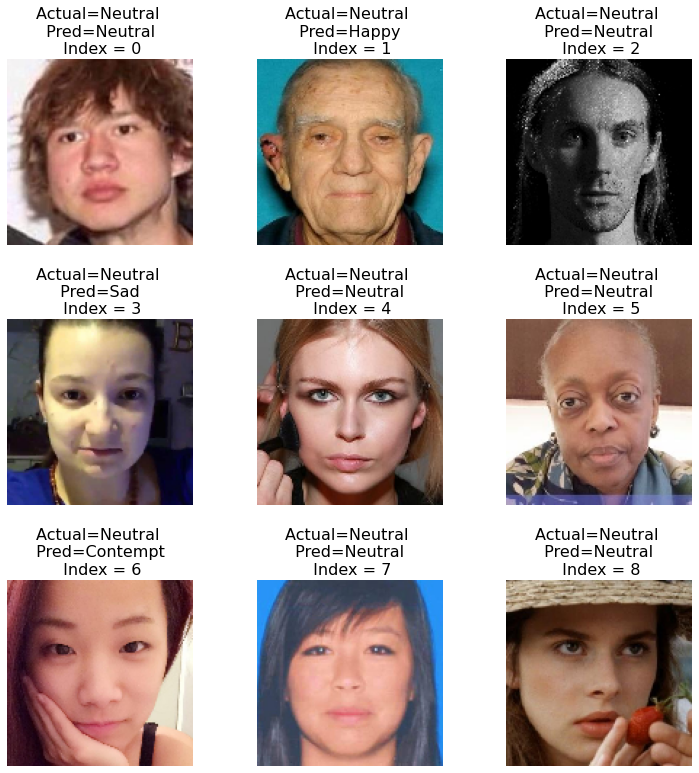

In [13]:
# displays first 9 images in array
start = 0

# gets labels for ground truth and predictions
true_labels = [CLASS_LABELS[idx] for idx in np.argmax(Y_img_true, axis=1)]
pred_labels = [CLASS_LABELS[idx] for idx in np.argmax(Y_img_pred, axis=1)]

display_nine_images(X_img, true_labels, pred_labels, start)

### FAU Dataset

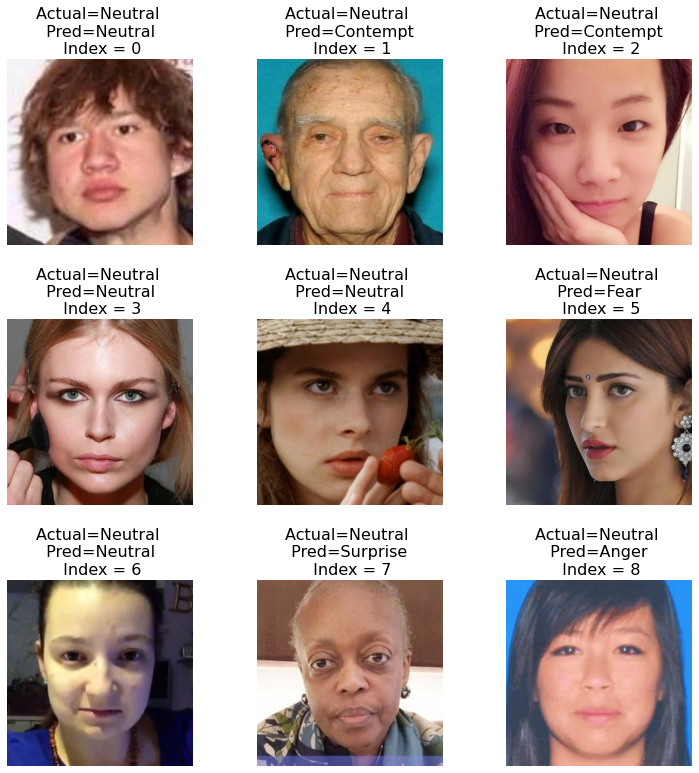

In [14]:
# displays first 9 images in array
start = 0

# Gets all images from folder
fau_images = [io.imread(f) for f in df_aus_xai.image]

# gets labels for ground truth and predictions
true_labels = [CLASS_LABELS[idx] for idx in Y_aus_true]
pred_labels = [CLASS_LABELS[idx] for idx in Y_aus_pred]

display_nine_images(fau_images, true_labels, pred_labels, start)

## Explanations with DiCE
In this part of the notebook, you will generate Counterfactual Explanations using the Python Library, [Diverse Counterfactual Explanations (DiCE)](http://interpret.ml/DiCE/).

Counterfactual explanations typically work on tabular data, so in this part we will be using the FAU dataset.

In [15]:
# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions

In [16]:
# identify categorical and numerical features as needed by DiCE
categorical_features = list(df_aus_train.columns[df_aus_train.columns.str.contains('_c')])
numerical_features = list(df_aus_train.columns[df_aus_train.columns.str.contains('_r')])

all_features = numerical_features + categorical_features 

### Select Images
Here we are selecting which images we would like to generate explanations for. Use the images plots above to find some interesting images to explain.

Additionally, we setup the 'desired' classes we would like to use for counterfactual explanations.

In [17]:
#### Enter the Indexes Here ### 
###############################
img_idxs = [3, 7, 27, 24]

# Enter the desired class for wi
desired_classes = [1, 0, 1, 2]

# img_idxs_cnn = [4, 5, 22, 21]

### Create a DiCE explanations
Now use DiCE to generate a set counterfactual explanations for your selected images.

See the [intro to DiCE](http://interpret.ml/DiCE/notebooks/DiCE_getting_started.html) for details on working with this library.

Note: the DiCE Data class requires a dataframe for creating explainers and explanations. 
- To set up the explainer you can use the following to create a dataframe of features and labels from the training data
    - `df_aus_train[all_features+['class']`
- for generating instances to explain, you can use the following code:
    - `df_aus_xai[all_features][40:41]` where 40 is the index of instance to explan since the explainer requires a 2-dim matrix

In [18]:
##### Create Explanation ######
###############################
d = dice_ml.Data(dataframe=df_aus_train[all_features+['class']], continuous_features=numerical_features, outcome_name='class')
m = dice_ml.Model(model=fer_rdf_model, backend='sklearn')
exp = dice_ml.Dice(d, m, method='random')

### Use the Explainer to Generate Counterfactual Explanations

Generate counterfacutal explanations for each of your selected data instances.

In [19]:
######## Explanations #########
###############################
exps = []
for idx, desired in zip(img_idxs, desired_classes):
    e = exp.generate_counterfactuals(df_aus_xai[all_features][idx:idx+1], total_CFs=5, desired_class=desired)
    exps.append(e)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


### Show Counterfactual Results

Now we plot the images and the corresponding counterfactuals as Pandas dataframes

In [20]:
pd.set_option('display.max_columns', None) # so that Jupyter doesn't truncate columns of dataframe

def show_exp(e_idx):
    e, idx, desired = exps[e_idx], img_idxs[e_idx], desired_classes[e_idx]
    print(f'###################################')
    print(f'#### Instance {idx} - True: {true_labels[idx]} ({Y_aus_true[idx]}), Pred: {pred_labels[idx]} ({Y_aus_pred[idx]})')
    print(f'#### Desired Outcome: {CLASS_LABELS[desired]} ({desired})')
    print()
    display_one_image(fau_images[idx], '', 111)
    plt.show()
    e.visualize_as_dataframe(show_only_changes=True)
    print()
    print()
    print()

###################################
#### Instance 3 - True: Neutral (0), Pred: Neutral (0)
#### Desired Outcome: Happy (1)



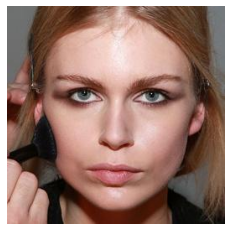

Query instance (original outcome : 0)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,0.0,0.0,0.0,0.66,0.0,0.0,0.0,0.0,0.0,0.19,0.0,0.0,0.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0



Diverse Counterfactual set (new outcome: 1)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,-,-,-,-,4.5,-,-,-,4.4,1.0899999999999999,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0
1,-,-,-,-,-,-,-,-,4.4,1.0899999999999999,-,1.1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,2.1,-,-,-,-,-,3.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0
3,0.5,-,-,-,-,-,-,-,4.4,1.0899999999999999,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0
4,-,-,-,-,-,-,-,-,1.5,1.0899999999999999,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,1.0


In [21]:
show_exp(0)

###################################
#### Instance 7 - True: Neutral (0), Pred: Surprise (3)
#### Desired Outcome: Neutral (0)



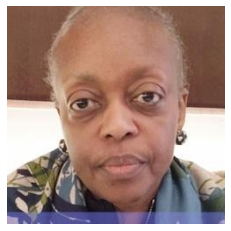

Query instance (original outcome : 3)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,2.1,2.92,0.0,1.91,0.0,0.0,0.0,0.0,0.0,0.0,0.26,0.0,0.6,0.02,0.69,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3



Diverse Counterfactual set (new outcome: 0)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,2.0,-,-,0.1,-,-,-,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,0.0,-,-,-,0.0
1,3.000000000000001,-,1.1,-,-,-,-,-,-,-,-,-,-,0.0,-,-,1.3,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,-,0.0
2,2.0,-,-,0.3,-,1.4,-,-,-,-,-,-,-,1.02,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0
3,2.0,-,1.1,-,-,-,-,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,-,-
4,2.0,-,-,0.6,-,-,-,-,-,-,-,-,-,0.0,-,-,3.1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0


In [22]:
show_exp(1)

###################################
#### Instance 27 - True: Sad (2), Pred: Sad (2)
#### Desired Outcome: Happy (1)



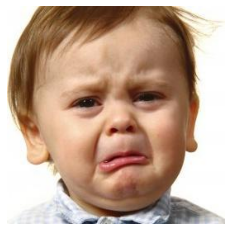

Query instance (original outcome : 2)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,0.74,0.0,0.89,0.0,0.41,4.19,1.75,1.31,0.0,0.05,1.67,0.71,2.28,0.61,0.0,0.22,0.17,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,2



Diverse Counterfactual set (new outcome: 1)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,-,-,-,-,-,5.089999999999997,-,-,2.7,0.0,-,5.1,-,-,-,-,0.0,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-,-
1,-,-,-,-,-,5.089999999999997,-,-,4.7,0.0,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-
2,-,-,-,-,3.6,5.089999999999997,-,-,3.3,1.0499999999999998,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,1.0
3,-,-,-,-,-,5.089999999999997,-,-,4.7,2.7,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,1.0
4,-,-,-,-,-,4.0,-,-,4.8,0.0,-,-,1.0,-,-,-,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,5.0


In [23]:
show_exp(2)

###################################
#### Instance 24 - True: Sad (2), Pred: Neutral (0)
#### Desired Outcome: Sad (2)



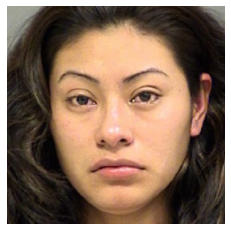

Query instance (original outcome : 0)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,1.64,2.09,0.18,0.05,0.0,0.0,0.0,0.37,0.04,0.49,1.36,0.48,0.55,0.0,0.0,0.0,0.3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0



Diverse Counterfactual set (new outcome: 2)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,-,2.0,-,0.0,-,-,-,-,3.2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2.0
1,-,3.0900000000000007,4.1,1.0499999999999998,-,-,-,-,1.04,-,2.9,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2.0
2,-,2.0,-,0.0,-,-,-,-,3.4,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2.0
3,1.8,3.0900000000000007,-,0.0,-,-,1.7,-,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2.0
4,-,3.0900000000000007,-,1.0499999999999998,-,-,-,-,0.0,-,-,-,1.1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2.0


In [24]:
show_exp(3)

### Observations

![Action Units](assets/fac.jpg)

1. Which features are most important for the detection of the specific facials expressions of your data instances?  Do the counterfactuals make sense according to your intuition of the contrastive expression class you're using
2. The `generate_counterfactuals` method has a parameter `features_to_vary` so that we can restrict which features are perturbed in CF generation.  Are there any AUs that shouldn't be perturbed for our task of emotion detection? Why or why not? Additionally, should we set `permitted_range` parameter to limit the ranges of our continous features?

### Generate Feature Attribution Scores with DiCE

DiCE can also generate [local and global feature attribution scores](http://interpret.ml/DiCE/notebooks/DiCE_getting_started.html#Generating-feature-attributions-(local-and-global)-using-DiCE) based on the identified counterfactuals for identifying which features are important for the counterfactual class.  In this section, we will do just that.  

In [25]:
# function for plotting importance dictionaries provided by DiCE
def plot_importance_dict(importance_dict, subplot):
    keys = list(importance_dict.keys())
    vals = [float(importance_dict[k]) for k in keys]
    plt.subplot(subplot)
    sns.barplot(x=keys, y=vals)
    plt.xticks(rotation=45)

#### Generate and Plot Local Importance Scores

Using your previously defined DiCE explainer, generate and plot local importance scores for your data instances.

In [26]:
###### plot importance ########
###############################
from IPython.display import display, HTML
def plot_local_importance(e_idx):
    e, idx, desired = exps[e_idx], img_idxs[e_idx], desired_classes[e_idx]
    print(f'###################################')
    print(f'#### Instance {idx} - True: {true_labels[idx]} ({Y_aus_true[idx]}), Pred: {pred_labels[idx]} ({Y_aus_pred[idx]})')
    print(f'#### Desired Outcome: {CLASS_LABELS[desired]} ({desired})')
    print(f'\n### Current FAUs')
    display(df_aus_xai[all_features].iloc[idx:idx+1])
    print(f'\n### Feature Attribution')
    imp = exp.local_feature_importance(df_aus_xai[all_features][idx:idx+1], total_CFs=10, desired_class=desired)
    plt.figure(figsize=(28, 4))
    display_one_image(fau_images[idx], '', 121)
    plot_importance_dict(imp.local_importance[0], 122)
    plt.show()

###################################
#### Instance 3 - True: Neutral (0), Pred: Neutral (0)
#### Desired Outcome: Happy (1)

### Current FAUs


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
3,0.0,0.0,0.0,0.66,0.0,0.0,0.0,0.0,0.0,0.19,0.0,0.0,0.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0



### Feature Attribution


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


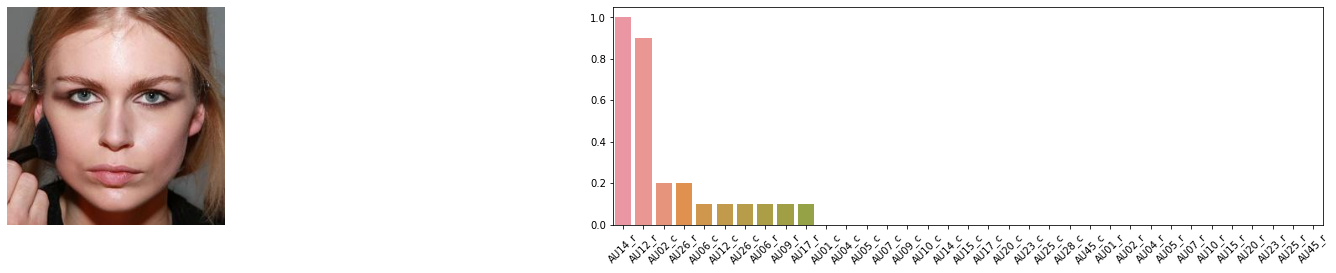

In [27]:
plot_local_importance(0)

###################################
#### Instance 7 - True: Neutral (0), Pred: Surprise (3)
#### Desired Outcome: Neutral (0)

### Current FAUs


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
7,2.1,2.92,0.0,1.91,0.0,0.0,0.0,0.0,0.0,0.0,0.26,0.0,0.6,0.02,0.69,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0



### Feature Attribution


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


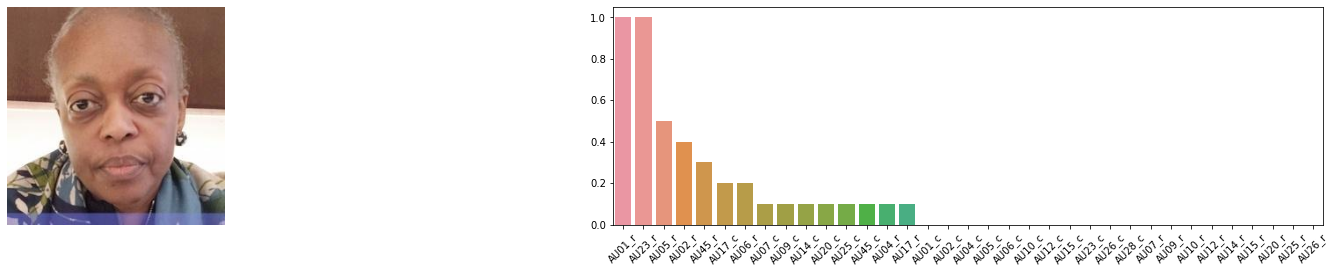

In [28]:
plot_local_importance(1)

###################################
#### Instance 27 - True: Sad (2), Pred: Sad (2)
#### Desired Outcome: Happy (1)

### Current FAUs


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
27,0.74,0.0,0.89,0.0,0.41,4.19,1.75,1.31,0.0,0.05,1.67,0.71,2.28,0.61,0.0,0.22,0.17,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0



### Feature Attribution


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


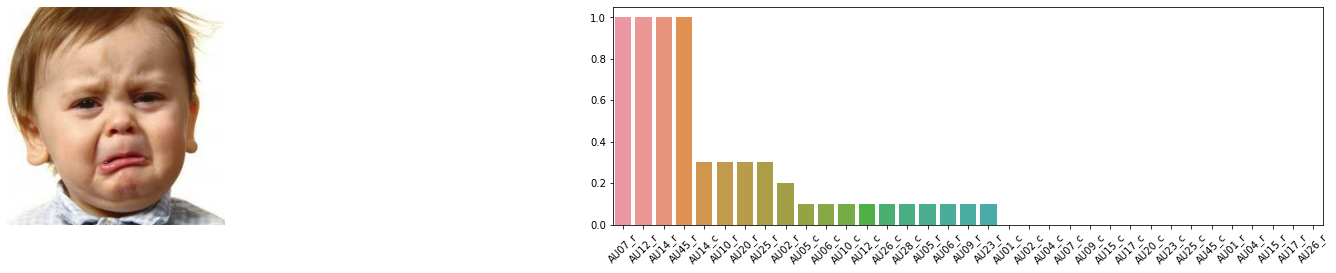

In [29]:
plot_local_importance(2)

###################################
#### Instance 24 - True: Sad (2), Pred: Neutral (0)
#### Desired Outcome: Sad (2)

### Current FAUs


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
24,1.64,2.09,0.18,0.05,0.0,0.0,0.0,0.37,0.04,0.49,1.36,0.48,0.55,0.0,0.0,0.0,0.3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0



### Feature Attribution


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.28s/it]


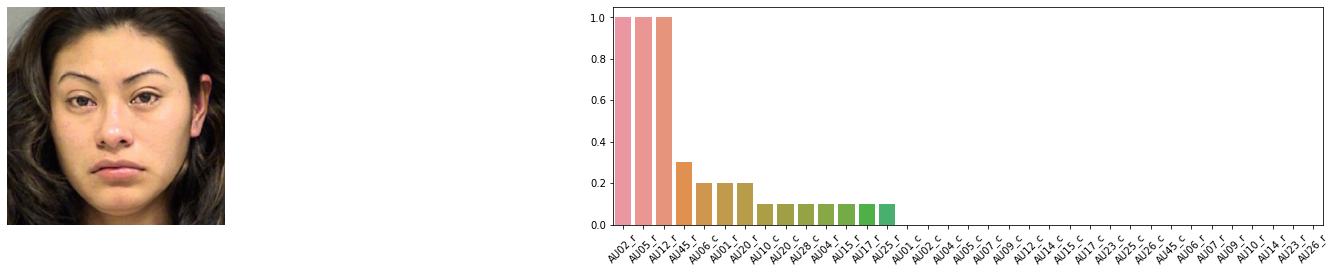

In [30]:
plot_local_importance(3)

#### Generate and Plot Global Importance Scores

Using your previously defined DiCE explainer, generate and plot global importance scores for the data instances.

In [31]:
CLASS_LABELS

['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']

#### Global Feature Importance For Class: Happy


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.11s/it]


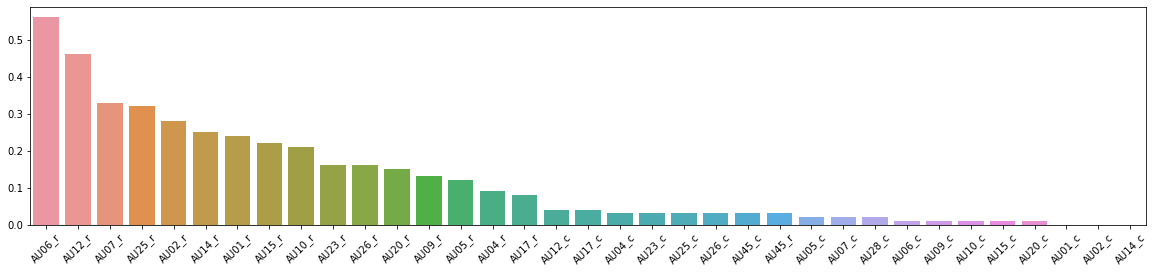

In [32]:
###### Global Importance ######
###############################
label2exp = 'Happy'
cls_idx = CLASS_LABELS.index(label2exp) # choose a label to get feature importance values
print(f'#### Global Feature Importance For Class: {CLASS_LABELS[cls_idx]}')
imp = exp.global_feature_importance(df_aus_xai[all_features][cls_idx*10:cls_idx*10+10], desired_class=1)  # use 10 images with label2exp
plt.figure(figsize=(20, 4))
plot_importance_dict(imp.summary_importance, 111)

#### Observations

![Action Units](assets/fac.jpg)

1. How does DiCE calculate feature importance from counterfactuals?
1. Do the plots lead to any interesting insights regarding AUs or facial expression detection?